In [4]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
import seaborn as sns
from ExplainableMaximumLikelihoodCalculator import ExplainableMaximumLikelihoodCalculator
import pysam
from Bio import SeqIO, Seq, SeqRecord, pairwise2
from Bio.pairwise2 import format_alignment
from LoadDataUtils import getListOfReadsFromBamFile, getListOfReadsFromFastaFile
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import math
import shap
import time
import matplotlib.pyplot as plt
import numpy as np

from scipy.stats import chisquare
from scipy.special import rel_entr
fileNameSapiens =  "data/simulatedData/human_chinese_AF346973_500samples.fas" #File that contains 500 reads from homo sapiens
fileNameNeanderthals =  "data/simulatedData/Neanderthal_Goyet_KX198085_500samples.fas" #File that contains 500 reads from neanderthal
fileNameDenisovans =  "data/simulatedData/denisova_kx663333_500samples.fas" #File that contains 500 reads from denisovan
neanderthals_500_generated = getListOfReadsFromFastaFile(fileNameNeanderthals)
sapiens_500_generated = getListOfReadsFromFastaFile(fileNameSapiens)
denisovan_500_samples = getListOfReadsFromFastaFile(fileNameDenisovans)
path_to_frequencies_table = "data/substitution_matrix.tsv"

In [5]:
real_data = getListOfReadsFromFastaFile("data/RealData/fasta_of_merged_50_50.fas")
use_real_data = True

In [6]:
sapiens_reference_file_names = [
                    "data/reference_files/human_AF346981_French.fa",
                     "data/reference_files/human_AY195760_Korea.fa",
                      "data/reference_files/human_AY882416_Ethiopia.fa",
                      "data/reference_files/human_AY963586_Italian.fa",
                      "data/reference_files/human_AY195781_Caucasian.fa",
                      "data/reference_files/human_AY195757_Iraqi-Israeli.fa",
                      "data/reference_files/human_AY195749_NativeAmerican.fa"]
neanderthals_reference_file_names = [
                            "data/reference_files/neanderthal_mezmaiskaya1_FM865411.fa",
                           "data/reference_files/Neanderthal_Altai_KC879692.fa",
                           "data/reference_files/Neanderthal_Denisova11_full_mtDNA_KU131206.fa",
                           "data/reference_files/Neanderthal_Spy_94a_MG025538.fa",
                            "data/reference_files/Neanderthal_Vindija33.16_AM948965.fa",
                            "data/reference_files/Neanderthal_Vindija33.19_KJ533545.fa"]
denisovan_reference_file_names = [  
                        "data/reference_files/Denisova_MT576653.1.fa",
                        "data/reference_files/Denisova_MT576652.1.fa",
                        "data/reference_files/Denisova_4_FR695060.fa",
                        "data/reference_files/Denisova_8_KT780370.fa",
                        "data/reference_files/Denisova_manual_phalanx_NC_013993.fa",
                        "data/reference_files/Denisova_MT576651.1.fa"]

## Data experiment

In [10]:
pre_processing_times = []
maximization_times = []
mc_times = []
shap_times = []
ref_calculation_times = []
counter_factual_calc_times = []
general_time_for_all = []
algorithm_1_running_times = []
dataset_sizes = [10,20,30,40,50,60,70,80,90,100]
number_of_experiments = 1
def generate_sample(sap, nean, den):
    list_before =  list(np.random.choice(sapiens_500_generated, sap)) + list(np.random.choice(neanderthals_500_generated, nean)) + list(np.random.choice(denisovan_500_samples, den))
    l = []
    for i in list_before:
        l.append(str(i))
    return l

def generate_sample_real_data(size):
    list_before =  list(np.random.choice(real_data, size))
    l = []
    for i in list_before:
        l.append(str(i))
    return l

In [11]:
for i in range(number_of_experiments):
    print("starting experiment number: ", i)
    for size in dataset_sizes:
        if  (use_real_data):
            dataset_1 = generate_sample_real_data(size)
        else:  
            biggest = int(size / 2)
            second = int((size - biggest)/2)
            third = size - biggest - second
            print(biggest, second, third)
            number_of_sapienses = biggest
            number_of_neanderthals = second
            number_of_denisovans = third
            dataset_1 = generate_sample(number_of_sapienses, number_of_neanderthals, number_of_denisovans)
        start_all = time.perf_counter()
        maximum_likelihood_calculator_d_1 = ExplainableMaximumLikelihoodCalculator(dataset_1,
                                                    ref_neanderthal_file_names=neanderthals_reference_file_names,
                                                    ref_sapien_file_names=sapiens_reference_file_names,
                                                    ref_denisovan_file_names=denisovan_reference_file_names,
                                                    path_to_substitution_matrix=path_to_frequencies_table,
                                                    number_of_jobs=-1)
        after_pre_processing = time.perf_counter()
        time_of_preprocessing = after_pre_processing - start_all
        pre_processing_times.append((size,time_of_preprocessing))
        print("finish_1")

        estimation = maximum_likelihood_calculator_d_1.estimate_species_proportions(result_resolution=50)
        after_maximization = time.perf_counter()
        time_of_maximization = after_maximization - after_pre_processing
        maximization_times.append((size,time_of_maximization))
        entire_algorithm_1 =  after_maximization - start_all
        algorithm_1_running_times.append((size,entire_algorithm_1))
        print("finish_2")

        sample_sizes = [1,5,10,20,30,50,100,200,400,600,800,1000]
        
        for sample_size in sample_sizes:
            print("running shap with sample size:", sample_size, "with data size:", size)
            time_before_shap = time.perf_counter()
            shaps = maximum_likelihood_calculator_d_1.calculate_shapley_values(sample_size)
            time_after_shap = time.perf_counter()
            time_shap_took = time_after_shap - time_before_shap
            shap_times.append((size, sample_size, time_shap_took))
        
        # for sample_size in sample_sizes:
        #     print("running mc estimation with sample size:", sample_size, "with data size:", size)
        #     time_before_mc = time.perf_counter()
        #     shaps = maximum_likelihood_calculator_d_1.estimate_shapley_values(number_of_samples_per_read = sample_size)
        #     time_after_smc= time.perf_counter()
        #     time_shap_took = time_after_smc - time_before_mc
        #     mc_times.append((size, sample_size, time_shap_took))
            
        print("algorithm 1 running time:", algorithm_1_running_times)
        print("shap times:", shap_times)
        print("mc times:", mc_times)
        # ref = maximum_likelihood_calculator_d_1.analyze_diff_on_removing_reference(number_of_samples=100,size_of_sample=8,result_resolution=50)
        # after_ref_calculation = time.perf_counter()
        # time_of_ref_calculation = after_ref_calculation - after_shapley
        # ref_calculation_times.append((size,time_of_ref_calculation))
        # print("finish_4")

        # cf = maximum_likelihood_calculator_d_1.generateCounterFactualMinimalSetToRemoveAndChangeMax(shapleys)
        # after_counter_factual = time.perf_counter()
        # time_of_cf_calculation = after_counter_factual - after_ref_calculation
        # counter_factual_calc_times.append((size,time_of_cf_calculation))


starting experiment number:  0
Loading sequences and calculating alignments to all references, this might take a while. Number of reads:  10
start working on read number 0
finish_1
finish_2
running shap with sample size: 1 with data size: 10
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
1
running shap with sample size: 5 with data size: 10
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
5
running shap with sample size: 10 with data size: 10
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
10
running shap with sample size: 20 with data size: 10
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
20
running shap with sample size: 30 with data size: 10
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
30
running shap with sample size: 50 with data size: 10
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
50
running shap with sample size: 100 with data size: 10
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
100
running shap with sample size: 200 with data size: 10
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
200
running shap with sample size: 400 with data size: 10
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
400
running shap with sample size: 600 with data size: 10
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
600
running shap with sample size: 800 with data size: 10
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
800
running shap with sample size: 1000 with data size: 10
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
1000
algorithm 1 running time: [(10, 36.979782111011446)]
shap times: [(10, 1, 0.9583084320183843), (10, 5, 1.2341979579941835), (10, 10, 1.0939882539969403), (10, 20, 1.2254540550056845), (10, 30, 1.492087287013419), (10, 50, 1.5765212750120554), (10, 100, 2.2741091850039084), (10, 200, 4.450663307012292), (10, 400, 6.415339119994314), (10, 600, 9.82729852598277), (10, 800, 14.13862849099678), (10, 1000, 16.990117239998654)]
mc times: []
Loading sequences and calculating alignments to all references, this might take a while. Number of reads:  20
start working on read number 0
finish_1
finish_2
running shap with sample size: 1 with data size: 20
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
1
running shap with sample size: 5 with data size: 20
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
5
running shap with sample size: 10 with data size: 20
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
10
running shap with sample size: 20 with data size: 20
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
20
running shap with sample size: 30 with data size: 20
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
30
running shap with sample size: 50 with data size: 20
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
50
running shap with sample size: 100 with data size: 20
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
100
running shap with sample size: 200 with data size: 20
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
200
running shap with sample size: 400 with data size: 20
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
400
running shap with sample size: 600 with data size: 20
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
600
running shap with sample size: 800 with data size: 20
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
800
running shap with sample size: 1000 with data size: 20
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
1000
algorithm 1 running time: [(10, 36.979782111011446), (20, 49.89881650501047)]
shap times: [(10, 1, 0.9583084320183843), (10, 5, 1.2341979579941835), (10, 10, 1.0939882539969403), (10, 20, 1.2254540550056845), (10, 30, 1.492087287013419), (10, 50, 1.5765212750120554), (10, 100, 2.2741091850039084), (10, 200, 4.450663307012292), (10, 400, 6.415339119994314), (10, 600, 9.82729852598277), (10, 800, 14.13862849099678), (10, 1000, 16.990117239998654), (20, 1, 1.096559122990584), (20, 5, 1.2230667539988644), (20, 10, 1.2745034309918992), (20, 20, 1.58105860100477), (20, 30, 1.933937813009834), (20, 50, 2.233374816016294), (20, 100, 3.8361531700065825), (20, 200, 6.116974606993608), (20, 400, 11.814977917005308), (20, 600, 19.159665464016143), (20, 800, 26.737085915985517), (20, 1000, 31.334491460991558)]
mc times: []
Loading sequences and calculating alignments to all references, this might take a while. Number of reads:  30
start working on read number 0
finish_1
finish_2
running shap

  0%|          | 0/1 [00:00<?, ?it/s]

1
1
running shap with sample size: 5 with data size: 30
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
5
running shap with sample size: 10 with data size: 30
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
10
running shap with sample size: 20 with data size: 30
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
20
running shap with sample size: 30 with data size: 30
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
30
running shap with sample size: 50 with data size: 30
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
50
running shap with sample size: 100 with data size: 30
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
100
running shap with sample size: 200 with data size: 30
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
200
running shap with sample size: 400 with data size: 30
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
400
running shap with sample size: 600 with data size: 30
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
600
running shap with sample size: 800 with data size: 30
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
800
running shap with sample size: 1000 with data size: 30
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
1000
algorithm 1 running time: [(10, 36.979782111011446), (20, 49.89881650501047), (30, 109.55784690199653)]
shap times: [(10, 1, 0.9583084320183843), (10, 5, 1.2341979579941835), (10, 10, 1.0939882539969403), (10, 20, 1.2254540550056845), (10, 30, 1.492087287013419), (10, 50, 1.5765212750120554), (10, 100, 2.2741091850039084), (10, 200, 4.450663307012292), (10, 400, 6.415339119994314), (10, 600, 9.82729852598277), (10, 800, 14.13862849099678), (10, 1000, 16.990117239998654), (20, 1, 1.096559122990584), (20, 5, 1.2230667539988644), (20, 10, 1.2745034309918992), (20, 20, 1.58105860100477), (20, 30, 1.933937813009834), (20, 50, 2.233374816016294), (20, 100, 3.8361531700065825), (20, 200, 6.116974606993608), (20, 400, 11.814977917005308), (20, 600, 19.159665464016143), (20, 800, 26.737085915985517), (20, 1000, 31.334491460991558), (30, 1, 1.217628654994769), (30, 5, 1.4383228489896283), (30, 10, 2.5108562560053542), (30, 20, 1.9399308050051332), (30, 30, 2.2973916949995328), (30, 50, 3.

  0%|          | 0/1 [00:00<?, ?it/s]

1
1
running shap with sample size: 5 with data size: 40
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
5
running shap with sample size: 10 with data size: 40
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
10
running shap with sample size: 20 with data size: 40
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
20
running shap with sample size: 30 with data size: 40
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
30
running shap with sample size: 50 with data size: 40
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
50
running shap with sample size: 100 with data size: 40
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
100
running shap with sample size: 200 with data size: 40
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
200
running shap with sample size: 400 with data size: 40
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
400
running shap with sample size: 600 with data size: 40
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
600
running shap with sample size: 800 with data size: 40
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
800
running shap with sample size: 1000 with data size: 40
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
1000
algorithm 1 running time: [(10, 36.979782111011446), (20, 49.89881650501047), (30, 109.55784690199653), (40, 121.88443845001166)]
shap times: [(10, 1, 0.9583084320183843), (10, 5, 1.2341979579941835), (10, 10, 1.0939882539969403), (10, 20, 1.2254540550056845), (10, 30, 1.492087287013419), (10, 50, 1.5765212750120554), (10, 100, 2.2741091850039084), (10, 200, 4.450663307012292), (10, 400, 6.415339119994314), (10, 600, 9.82729852598277), (10, 800, 14.13862849099678), (10, 1000, 16.990117239998654), (20, 1, 1.096559122990584), (20, 5, 1.2230667539988644), (20, 10, 1.2745034309918992), (20, 20, 1.58105860100477), (20, 30, 1.933937813009834), (20, 50, 2.233374816016294), (20, 100, 3.8361531700065825), (20, 200, 6.116974606993608), (20, 400, 11.814977917005308), (20, 600, 19.159665464016143), (20, 800, 26.737085915985517), (20, 1000, 31.334491460991558), (30, 1, 1.217628654994769), (30, 5, 1.4383228489896283), (30, 10, 2.5108562560053542), (30, 20, 1.9399308050051332), (30, 30, 2.2973

  0%|          | 0/1 [00:00<?, ?it/s]

1
1
running shap with sample size: 5 with data size: 50
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
5
running shap with sample size: 10 with data size: 50
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
10
running shap with sample size: 20 with data size: 50
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
20
running shap with sample size: 30 with data size: 50
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
30
running shap with sample size: 50 with data size: 50
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
50
running shap with sample size: 100 with data size: 50
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
100
running shap with sample size: 200 with data size: 50
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
200
running shap with sample size: 400 with data size: 50
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
400
running shap with sample size: 600 with data size: 50
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
600
running shap with sample size: 800 with data size: 50
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
800
running shap with sample size: 1000 with data size: 50
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
1000
algorithm 1 running time: [(10, 36.979782111011446), (20, 49.89881650501047), (30, 109.55784690199653), (40, 121.88443845001166), (50, 107.08572422800353)]
shap times: [(10, 1, 0.9583084320183843), (10, 5, 1.2341979579941835), (10, 10, 1.0939882539969403), (10, 20, 1.2254540550056845), (10, 30, 1.492087287013419), (10, 50, 1.5765212750120554), (10, 100, 2.2741091850039084), (10, 200, 4.450663307012292), (10, 400, 6.415339119994314), (10, 600, 9.82729852598277), (10, 800, 14.13862849099678), (10, 1000, 16.990117239998654), (20, 1, 1.096559122990584), (20, 5, 1.2230667539988644), (20, 10, 1.2745034309918992), (20, 20, 1.58105860100477), (20, 30, 1.933937813009834), (20, 50, 2.233374816016294), (20, 100, 3.8361531700065825), (20, 200, 6.116974606993608), (20, 400, 11.814977917005308), (20, 600, 19.159665464016143), (20, 800, 26.737085915985517), (20, 1000, 31.334491460991558), (30, 1, 1.217628654994769), (30, 5, 1.4383228489896283), (30, 10, 2.5108562560053542), (30, 20, 1.93993080

  0%|          | 0/1 [00:00<?, ?it/s]

1
1
running shap with sample size: 5 with data size: 60
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
5
running shap with sample size: 10 with data size: 60
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
10
running shap with sample size: 20 with data size: 60
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
20
running shap with sample size: 30 with data size: 60
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
30
running shap with sample size: 50 with data size: 60
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
50
running shap with sample size: 100 with data size: 60
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
100
running shap with sample size: 200 with data size: 60
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
200
running shap with sample size: 400 with data size: 60
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
400
running shap with sample size: 600 with data size: 60
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
600
running shap with sample size: 800 with data size: 60
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
800
running shap with sample size: 1000 with data size: 60
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
1000
algorithm 1 running time: [(10, 36.979782111011446), (20, 49.89881650501047), (30, 109.55784690199653), (40, 121.88443845001166), (50, 107.08572422800353), (60, 224.7550165640132)]
shap times: [(10, 1, 0.9583084320183843), (10, 5, 1.2341979579941835), (10, 10, 1.0939882539969403), (10, 20, 1.2254540550056845), (10, 30, 1.492087287013419), (10, 50, 1.5765212750120554), (10, 100, 2.2741091850039084), (10, 200, 4.450663307012292), (10, 400, 6.415339119994314), (10, 600, 9.82729852598277), (10, 800, 14.13862849099678), (10, 1000, 16.990117239998654), (20, 1, 1.096559122990584), (20, 5, 1.2230667539988644), (20, 10, 1.2745034309918992), (20, 20, 1.58105860100477), (20, 30, 1.933937813009834), (20, 50, 2.233374816016294), (20, 100, 3.8361531700065825), (20, 200, 6.116974606993608), (20, 400, 11.814977917005308), (20, 600, 19.159665464016143), (20, 800, 26.737085915985517), (20, 1000, 31.334491460991558), (30, 1, 1.217628654994769), (30, 5, 1.4383228489896283), (30, 10, 2.5108562560053

  0%|          | 0/1 [00:00<?, ?it/s]

1
1
running shap with sample size: 5 with data size: 70
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
5
running shap with sample size: 10 with data size: 70
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
10
running shap with sample size: 20 with data size: 70
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
20
running shap with sample size: 30 with data size: 70
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
30
running shap with sample size: 50 with data size: 70
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
50
running shap with sample size: 100 with data size: 70
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
100
running shap with sample size: 200 with data size: 70
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
200
running shap with sample size: 400 with data size: 70
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
400
running shap with sample size: 600 with data size: 70
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
600
running shap with sample size: 800 with data size: 70
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
800
running shap with sample size: 1000 with data size: 70
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
1000
algorithm 1 running time: [(10, 36.979782111011446), (20, 49.89881650501047), (30, 109.55784690199653), (40, 121.88443845001166), (50, 107.08572422800353), (60, 224.7550165640132), (70, 244.3696679819841)]
shap times: [(10, 1, 0.9583084320183843), (10, 5, 1.2341979579941835), (10, 10, 1.0939882539969403), (10, 20, 1.2254540550056845), (10, 30, 1.492087287013419), (10, 50, 1.5765212750120554), (10, 100, 2.2741091850039084), (10, 200, 4.450663307012292), (10, 400, 6.415339119994314), (10, 600, 9.82729852598277), (10, 800, 14.13862849099678), (10, 1000, 16.990117239998654), (20, 1, 1.096559122990584), (20, 5, 1.2230667539988644), (20, 10, 1.2745034309918992), (20, 20, 1.58105860100477), (20, 30, 1.933937813009834), (20, 50, 2.233374816016294), (20, 100, 3.8361531700065825), (20, 200, 6.116974606993608), (20, 400, 11.814977917005308), (20, 600, 19.159665464016143), (20, 800, 26.737085915985517), (20, 1000, 31.334491460991558), (30, 1, 1.217628654994769), (30, 5, 1.4383228489896283),

  0%|          | 0/1 [00:00<?, ?it/s]

1
1
running shap with sample size: 5 with data size: 80
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
5
running shap with sample size: 10 with data size: 80
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
10
running shap with sample size: 20 with data size: 80
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
20
running shap with sample size: 30 with data size: 80
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
30
running shap with sample size: 50 with data size: 80
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
50
running shap with sample size: 100 with data size: 80
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
100
running shap with sample size: 200 with data size: 80
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
200
running shap with sample size: 400 with data size: 80
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
400
running shap with sample size: 600 with data size: 80
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
600
running shap with sample size: 800 with data size: 80
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
800
running shap with sample size: 1000 with data size: 80
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
1000
algorithm 1 running time: [(10, 36.979782111011446), (20, 49.89881650501047), (30, 109.55784690199653), (40, 121.88443845001166), (50, 107.08572422800353), (60, 224.7550165640132), (70, 244.3696679819841), (80, 206.05867536598817)]
shap times: [(10, 1, 0.9583084320183843), (10, 5, 1.2341979579941835), (10, 10, 1.0939882539969403), (10, 20, 1.2254540550056845), (10, 30, 1.492087287013419), (10, 50, 1.5765212750120554), (10, 100, 2.2741091850039084), (10, 200, 4.450663307012292), (10, 400, 6.415339119994314), (10, 600, 9.82729852598277), (10, 800, 14.13862849099678), (10, 1000, 16.990117239998654), (20, 1, 1.096559122990584), (20, 5, 1.2230667539988644), (20, 10, 1.2745034309918992), (20, 20, 1.58105860100477), (20, 30, 1.933937813009834), (20, 50, 2.233374816016294), (20, 100, 3.8361531700065825), (20, 200, 6.116974606993608), (20, 400, 11.814977917005308), (20, 600, 19.159665464016143), (20, 800, 26.737085915985517), (20, 1000, 31.334491460991558), (30, 1, 1.217628654994769), (3

  0%|          | 0/1 [00:00<?, ?it/s]

1
1
running shap with sample size: 5 with data size: 90
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
5
running shap with sample size: 10 with data size: 90
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
10
running shap with sample size: 20 with data size: 90
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
20
running shap with sample size: 30 with data size: 90
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
30
running shap with sample size: 50 with data size: 90
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
50
running shap with sample size: 100 with data size: 90
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
100
running shap with sample size: 200 with data size: 90
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
200
running shap with sample size: 400 with data size: 90
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
400
running shap with sample size: 600 with data size: 90
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
600
running shap with sample size: 800 with data size: 90
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
800
running shap with sample size: 1000 with data size: 90
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
1000
algorithm 1 running time: [(10, 36.979782111011446), (20, 49.89881650501047), (30, 109.55784690199653), (40, 121.88443845001166), (50, 107.08572422800353), (60, 224.7550165640132), (70, 244.3696679819841), (80, 206.05867536598817), (90, 272.93429057797766)]
shap times: [(10, 1, 0.9583084320183843), (10, 5, 1.2341979579941835), (10, 10, 1.0939882539969403), (10, 20, 1.2254540550056845), (10, 30, 1.492087287013419), (10, 50, 1.5765212750120554), (10, 100, 2.2741091850039084), (10, 200, 4.450663307012292), (10, 400, 6.415339119994314), (10, 600, 9.82729852598277), (10, 800, 14.13862849099678), (10, 1000, 16.990117239998654), (20, 1, 1.096559122990584), (20, 5, 1.2230667539988644), (20, 10, 1.2745034309918992), (20, 20, 1.58105860100477), (20, 30, 1.933937813009834), (20, 50, 2.233374816016294), (20, 100, 3.8361531700065825), (20, 200, 6.116974606993608), (20, 400, 11.814977917005308), (20, 600, 19.159665464016143), (20, 800, 26.737085915985517), (20, 1000, 31.334491460991558), (30,

  0%|          | 0/1 [00:00<?, ?it/s]

1
1
running shap with sample size: 5 with data size: 100
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
5
running shap with sample size: 10 with data size: 100
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
10
running shap with sample size: 20 with data size: 100
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
20
running shap with sample size: 30 with data size: 100
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
30
running shap with sample size: 50 with data size: 100
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
50
running shap with sample size: 100 with data size: 100
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
100
running shap with sample size: 200 with data size: 100
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
200
running shap with sample size: 400 with data size: 100
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
400
running shap with sample size: 600 with data size: 100
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
600
running shap with sample size: 800 with data size: 100
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
800
running shap with sample size: 1000 with data size: 100
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
1000
algorithm 1 running time: [(10, 36.979782111011446), (20, 49.89881650501047), (30, 109.55784690199653), (40, 121.88443845001166), (50, 107.08572422800353), (60, 224.7550165640132), (70, 244.3696679819841), (80, 206.05867536598817), (90, 272.93429057797766), (100, 226.263813802012)]
shap times: [(10, 1, 0.9583084320183843), (10, 5, 1.2341979579941835), (10, 10, 1.0939882539969403), (10, 20, 1.2254540550056845), (10, 30, 1.492087287013419), (10, 50, 1.5765212750120554), (10, 100, 2.2741091850039084), (10, 200, 4.450663307012292), (10, 400, 6.415339119994314), (10, 600, 9.82729852598277), (10, 800, 14.13862849099678), (10, 1000, 16.990117239998654), (20, 1, 1.096559122990584), (20, 5, 1.2230667539988644), (20, 10, 1.2745034309918992), (20, 20, 1.58105860100477), (20, 30, 1.933937813009834), (20, 50, 2.233374816016294), (20, 100, 3.8361531700065825), (20, 200, 6.116974606993608), (20, 400, 11.814977917005308), (20, 600, 19.159665464016143), (20, 800, 26.737085915985517), (20, 1000, 

In [12]:
def getListOfAverages(list_of_data):
    averages = []
    for size in dataset_sizes:
        rel_data = [i[1] for i in list_of_data if i[0] ==size]
        avg = np.mean(rel_data)
        averages.append(avg)
    return averages

In [67]:
def plot(x,y, name, title):
    plt.figure() 
    plt.figure().clear()
    plt.rcParams.update({'font.size': 14})
    plt.plot(x, y)
    plt.title(title)
    plt.xlabel("Sample size")
    plt.ylabel("Execution time in seconds")
    plt.xlim(left=0)
    plt.ylim(bottom=0)
    plt.savefig(name)
    

    plt.show()

In [75]:
times_50 = [i[2] for i in shap_times if i[0] == 20]

In [73]:
times_50

[1.4312578800017945,
 1.8645689980185125,
 2.5419416559743695,
 3.1485247800010256,
 3.1727332760056015,
 4.1253797950048465,
 6.80754426799831,
 12.336662316985894,
 20.835201252019033,
 29.714895654004067,
 40.61047645000508,
 54.317526972008636]

<Figure size 640x480 with 0 Axes>

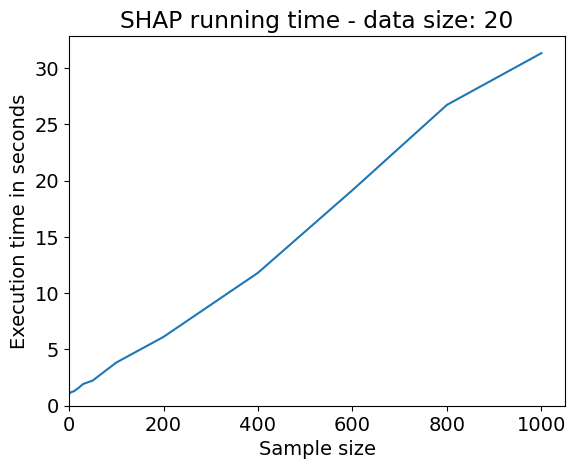

In [76]:
plot(sample_sizes, times_50, "shap_running_time_20.png", "SHAP running time - data size: 20" )

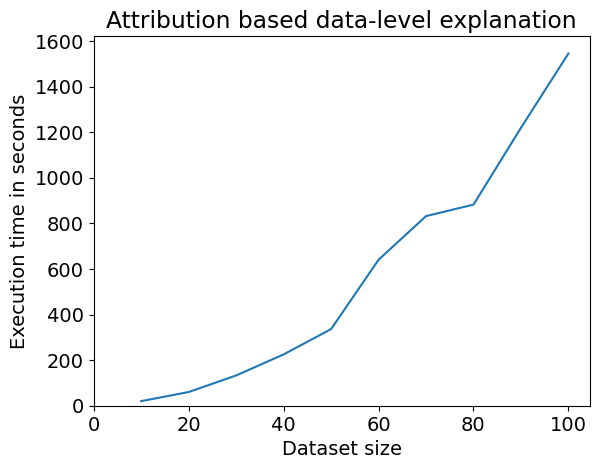

In [51]:
plot(dataset_sizes, getListOfAverages(shapley_estimation_times), "shapley_RealDataSizePlot.png", "Attribution based data-level explanation")

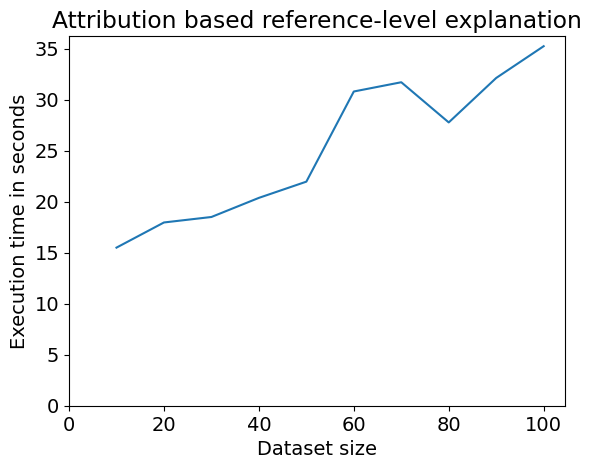

In [43]:
plot(dataset_sizes, getListOfAverages(ref_calculation_times), "reference_RealDataSizePlot.png", "Attribution based reference-level explanation")

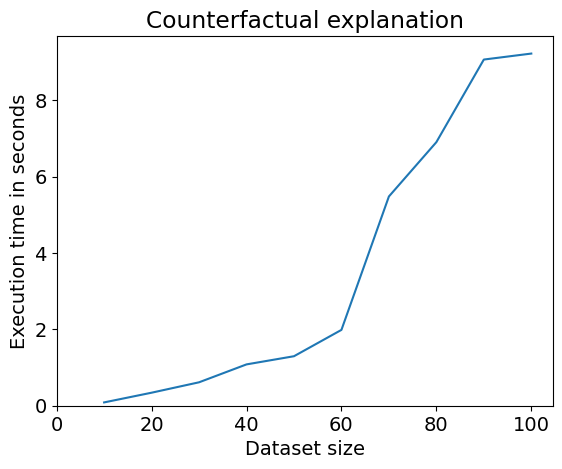

In [65]:
plot(dataset_sizes, getListOfAverages(counter_factual_calc_times), "counterfactual_RealDataSizePlot.png", "Counterfactual explanation")

# Threads

In [53]:
num_of_threads = [1,2,3,4,5,6,7,8]

In [54]:
pre_processing_times_threads = []
maximization_times_threads = []
shapley_estimation_times_threads = []
ref_calculation_times_threads = []
counter_factual_calc_times_threads = []
general_time_for_all_threads = []
algorithm_1_time_threads = []
number_of_exps = 1

In [55]:
for i in range(number_of_exps):    
    for threads in num_of_threads:
        if (use_real_data):
            dataset_1 = generate_sample_real_data(60)
        else:
            number_of_sapienses = 30
            number_of_neanderthals = 20
            number_of_denisovans = 10
            dataset_1 = neanderthals_500_generated[:number_of_neanderthals] + sapiens_500_generated[:number_of_sapienses] + denisovan_500_samples[:number_of_denisovans]
        start_all = time.perf_counter()
        maximum_likelihood_calculator_d_1 = ExplainableMaximumLikelihoodCalculator(dataset_1,
                                                    ref_neanderthal_file_names=neanderthals_reference_file_names,
                                                    ref_sapien_file_names=sapiens_reference_file_names,
                                                    ref_denisovan_file_names=denisovan_reference_file_names,
                                                    path_to_substitution_matrix=path_to_frequencies_table,
                                                    number_of_jobs=threads)
        after_pre_processing = time.perf_counter()
        time_of_preprocessing = after_pre_processing - start_all
        pre_processing_times_threads.append((threads, time_of_preprocessing))
        print("finish_1")

        estimation = maximum_likelihood_calculator_d_1.estimate_species_proportions(result_resolution=50)
        after_maximization = time.perf_counter()
        time_of_maximization = after_maximization - after_pre_processing
        maximization_times_threads.append((threads, time_of_maximization))
        entire_alg_time = after_maximization - start_all
        algorithm_1_time_threads.append((threads, entire_alg_time))
        print("finish_2")

        shapleys = maximum_likelihood_calculator_d_1.estimate_shapley_values(number_of_samples_per_read=50,number_of_jobs=threads)[0] #[0] is to get the scaled values
        after_shapley = time.perf_counter()
        time_of_shapley = after_shapley - after_maximization
        shapley_estimation_times_threads.append((threads, time_of_shapley))
        print("finish_3")

        ref = maximum_likelihood_calculator_d_1.analyze_diff_on_removing_reference(number_of_samples=100,size_of_sample=8,result_resolution=50)
        after_ref_calculation = time.perf_counter()
        time_of_ref_calculation = after_ref_calculation - after_shapley
        ref_calculation_times_threads.append((threads, time_of_ref_calculation))
        print("finish_4")

        cf = maximum_likelihood_calculator_d_1.generateCounterFactualMinimalSetToRemoveAndChangeMax(shapleys)
        after_counter_factual = time.perf_counter()
        time_of_cf_calculation = after_counter_factual - after_ref_calculation
        counter_factual_calc_times_threads.append((threads, time_of_cf_calculation))
        print("finish_5")

        general_time_for_all_threads.append((threads, after_counter_factual - start_all))
        print(general_time_for_all_threads)

Loading sequences and calculating alignments to all references, this might take a while. Number of reads:  60
start working on read number 0
start working on read number 40
finish_1
finish_2
finish_3
finish_4
Change dominating species from Homo Sapiens to Neanderthal would require removing 13 reads: [28, 8, 15, 54, 38, 44, 51, 34, 41, 40, 0, 11, 57]
finish_5
[(1, 1443.9724489159998)]
Loading sequences and calculating alignments to all references, this might take a while. Number of reads:  60
start working on read number 0
start working on read number 40
finish_1
finish_2
finish_3
finish_4
Change dominating species from Homo Sapiens to Neanderthal would require removing 11 reads: [27, 39, 43, 53, 18, 59, 37, 34, 21, 58, 48]
finish_5
[(1, 1443.9724489159998), (2, 1024.7924145949983)]
Loading sequences and calculating alignments to all references, this might take a while. Number of reads:  60
start working on read number 0
start working on read number 40
finish_1
finish_2
finish_3
finish_

In [66]:
def getListOfAveragesThreads(list_of_data):
    averages = []
    for size in num_of_threads:
        rel_data = [i[1] for i in list_of_data if i[0] ==size]
        avg = np.mean(rel_data)
        averages.append(avg)
    return averages

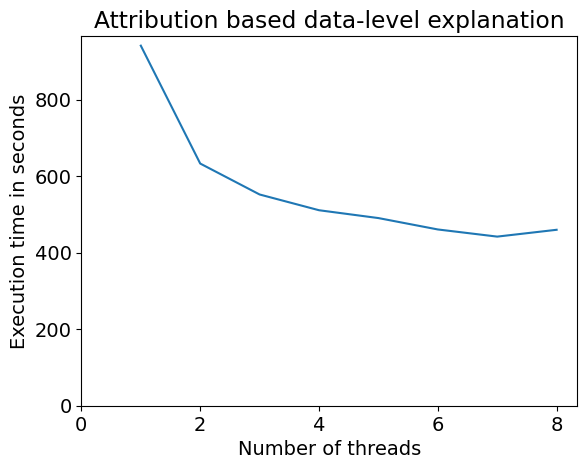

In [75]:
plotThreads(num_of_threads, getListOfAveragesThreads(shapley_estimation_times_threads), "numberOfThreadsToExecutionDataAttribution.png", "Attribution based data-level explanation")

In [57]:
plotThreads(num_of_threads, getListOfAveragesThreads(algorithm_1_time_threads), "numberOfThreadsToExecutionAlgorithm1.png", "Algorithm 1 execution time")

[1, 2, 3, 4, 5, 6, 7, 8]

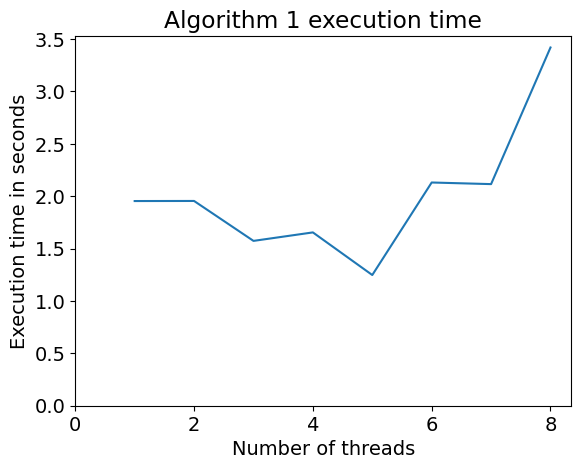

In [77]:
plotThreads(num_of_threads, getListOfAveragesThreads(counter_factual_calc_times_threads), "ba.png", "Algorithm 1 execution time")

In [73]:
def plotThreads(t,s, name, title):

    plt.rcParams.update({'font.size': 14})
    plt.plot(t, s)
    plt.title(title)
    plt.xlabel("Number of threads")
    plt.ylabel("Execution time in seconds")
    plt.xlim(left=0)
    plt.ylim(bottom=0)
    plt.savefig(name)

    plt.show()